In [1]:
import sqlite3

In [2]:
connect = sqlite3.connect('database.sqlite')
cur = connect.cursor()

In [3]:
!pip install pandas

# Task 2.1

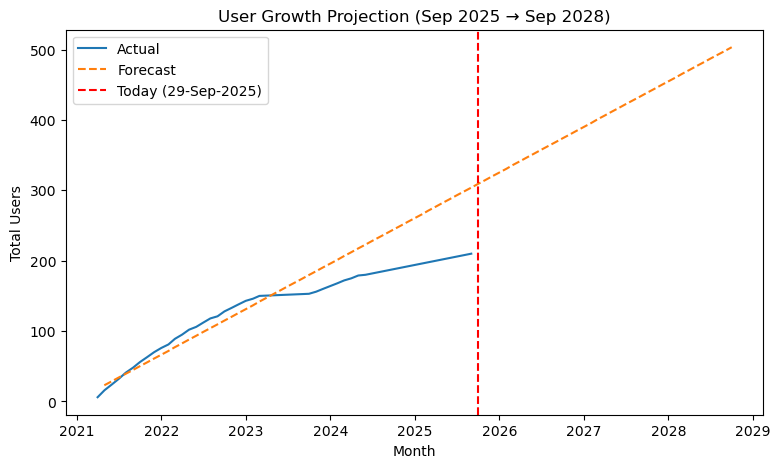

Servers required by Sep 2028 (+20% buffer): 49
Note: It is from September, 2025 till September, 2028


In [45]:

# loading the user data on bases of when its created
df = pd.read_sql("SELECT id, created_at FROM users", conn)
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna()

# counting total users by month
df["month"] = df["created_at"].dt.to_period("M").dt.to_timestamp()
monthlyUsers = df.groupby("month")["id"].count().cumsum().reset_index(name="total")

m, c = np.polyfit(range(len(monthlyUsers)), monthlyUsers["total"], 1)


#  Forecast from today (29 Sep 2025) 
todayDate = pd.Timestamp("2025-09-29")
endDate = todayDate + pd.DateOffset(years=3)  # +3 years till Sep 2028

# create timeline until Sep 2028
monthTotal = (endDate.to_period("M") - monthlyUsers["month"].min().to_period("M")).n + 1
xFuture = np.arange(monthTotal)
yFuture = m * xFuture + c
future_months = pd.date_range(monthlyUsers["month"].min(), periods=monthTotal, freq="M")

# estimate servers
currentUsers = np.interp(len(monthlyUsers)-1, xFuture, yFuture)  # approximate users today
future_users = yFuture[-1]
factor = future_users / currentUsers
servers = math.ceil(16 * factor * 1.2)

# plot results
plt.figure(figsize=(9,5))
plt.plot(monthlyUsers["month"], monthlyUsers["total"], label="Actual")
plt.plot(future_months, yFuture, '--', label="Forecast")
plt.axvline(todayDate, color="red", linestyle="--", label="Today (29-Sep-2025)")
plt.title("User Growth Projection (Sep 2025 → Sep 2028)")
plt.xlabel("Month")
plt.ylabel("Total Users")
plt.legend()
plt.show()

print("Servers required by Sep 2028 (+20% buffer):", servers)
print ("Note: It is from September, 2025 till September, 2028")

# Task 2.2

In [69]:

query = """
WITH reaction_counts AS (
  SELECT r.post_id, COUNT(*) AS reactions
  FROM reactions r
  GROUP BY r.post_id
),
comment_counts AS (
  SELECT c.post_id, COUNT(*) AS comments
  FROM comments c
  GROUP BY c.post_id
)
SELECT
  p.id            AS post_id,
  p.user_id,
  p.content,
  p.created_at,
  COALESCE(rc.reactions, 0) AS reaction_count,
  COALESCE(cc.comments, 0)  AS comment_count,
  COALESCE(rc.reactions, 0) + COALESCE(cc.comments, 0) AS score
FROM posts p
LEFT JOIN reaction_counts rc ON rc.post_id = p.id
LEFT JOIN comment_counts cc  ON cc.post_id  = p.id
"""

engagement = pd.read_sql(query, conn)

# attach usernames
users = pd.read_sql("SELECT id AS user_id, username FROM users", conn)
df = engagement.merge(users, on="user_id", how="left")

# take the top 3 by our simple virality metric (reactions + comments)
top3 = (
    df.sort_values("score", ascending=False)
      .head(3)
      .reset_index(drop=True)
)

# show a compact summary
cols = ["post_id", "username", "created_at", "reaction_count", "comment_count", "score", "content"]
print("Top 3 viral posts (by reactions + comments):\n")
for i, row in top3[cols].iterrows():
    print(f"#{i+1}")
    print(f"  Post ID     : {row['post_id']}")
    print(f"  Author      : {row.get('username')}")
    print(f"  Created     : {row['created_at']}")
    print(f"  Reactions   : {row['reaction_count']}")
    print(f"  Comments    : {row['comment_count']}")
    print(f"  Score       : {row['score']}")
    print(f"  Content     : {row['content']}")


Top 3 viral posts (by reactions + comments):

#1
  Post ID     : 2351
  Author      : PinkPetal
  Created     : 2025-02-15 11:48:26
  Reactions   : 139
  Comments    : 62
  Score       : 201
  Content     : Just finished a DIY project turning old pallets into a garden bench. It turned out better than I expected! ? #Upcycling
#2
  Post ID     : 2813
  Author      : eagle_eric
  Created     : 2025-07-11 16:08:47
  Reactions   : 103
  Comments    : 82
  Score       : 185
  Content     : Recently, I've been reflecting on the importance of kindness in everyday interactions. We all have the power to make the world a better place. #SpreadKindness
#3
  Post ID     : 2195
  Author      : BlueOcean
  Created     : 2025-03-01 10:10:54
  Reactions   : 133
  Comments    : 45
  Score       : 178
  Content     : Cooked up a vegan feast last night and managed to not burn anything! Progress, not perfection. #VeganLife #ChefInTheMaking


# Task 2.3

In [67]:

# load posts and comments from the respective tables 
posts = pd.read_sql("SELECT id, created_at FROM posts", conn)
comments = pd.read_sql("SELECT post_id, created_at FROM comments", conn)

# make sure dates are parsed correctly
posts["created_at"] = pd.to_datetime(posts["created_at"], errors="coerce")
comments["created_at"] = pd.to_datetime(comments["created_at"], errors="coerce")

# drop bad/missing values
posts = posts.dropna(subset=["created_at"])
comments = comments.dropna(subset=["created_at"])

# find the first and last comment time for each post
commentTimes = comments.groupby("post_id")["created_at"].agg(
    firstComment="min",
    lastComment="max"
).reset_index()

# join with posts to compare post time and the engagement time
df = posts.merge(commentTimes, left_on="id", right_on="post_id", how="inner")

# calculate time differences (in hours)
df["timeToFirst"] = (df["firstComment"] - df["created_at"]).dt.total_seconds() / 3600
df["timeToLast"] = (df["lastComment"] - df["created_at"]).dt.total_seconds() / 3600

# average across all posts
avg_first = df["timeToFirst"].mean()
avg_last = df["timeToLast"].mean()

print(f"Avg first engagement: {avg_first:.2f} hours")
print(f"Avg last engagement: {avg_last:.2f} hours")

#viewing a few rows to see details
print("\n Post lifecycle timings:")
print(df[["id", "created_at", "firstComment", "lastComment", "timeToFirst", "timeToLast"]].head())


Avg first engagement: 45.18 hours
Avg last engagement: 138.95 hours

 Post lifecycle timings:
     id          created_at        firstComment         lastComment  \
0  1718 2023-10-12 10:43:24 2023-10-13 00:45:50 2023-10-17 18:08:16   
1  1719 2023-12-05 21:30:24 2023-12-07 12:27:03 2023-12-09 12:54:02   
2  1720 2024-03-18 12:13:24 2024-03-18 15:59:48 2024-03-25 09:43:33   
3  1721 2024-06-01 16:43:24 2024-06-02 19:29:15 2024-06-08 09:42:22   
4  1722 2024-08-09 10:58:24 2024-08-11 20:41:58 2024-08-12 22:42:08   

   timeToFirst  timeToLast  
0    14.040556  127.414444  
1    38.944167   87.393889  
2     3.773333  165.502500  
3    26.764167  160.982778  
4    57.726111   83.728889  


# Task 2.4

In [70]:
 
# SQL: count how often people interact with each other (via comments + reactions)
query = """
WITH all_engagements AS (
    -- likes/reactions
    SELECT p.user_id AS owner, r.user_id AS actor, COUNT(*) AS cnt
    FROM reactions r
    JOIN posts p ON p.id = r.post_id
    WHERE r.user_id != p.user_id
    GROUP BY p.user_id, r.user_id

    UNION ALL

    -- comments
    SELECT p.user_id AS owner, c.user_id AS actor, COUNT(*) AS cnt
    FROM comments c
    JOIN posts p ON p.id = c.post_id
    WHERE c.user_id != p.user_id
    GROUP BY p.user_id, c.user_id
),

pairwise AS (
    SELECT
        CASE WHEN owner < actor THEN owner ELSE actor END AS user1,
        CASE WHEN owner < actor THEN actor ELSE owner END AS user2,
        SUM(cnt) AS total_engagements
    FROM all_engagements
    GROUP BY user1, user2
)

SELECT user1, user2, total_engagements
FROM pairwise
ORDER BY total_engagements DESC
LIMIT 3;
"""

# run query and bring into pandas
pairs = pd.read_sql(query, conn)

# get usernames
users = pd.read_sql("SELECT id, username FROM users", conn)

# add readable names
pairs = (pairs
    .merge(users, left_on="user1", right_on="id").rename(columns={"username":"user1_name"}).drop(columns=["id"])
    .merge(users, left_on="user2", right_on="id").rename(columns={"username":"user2_name"}).drop(columns=["id"])
)

# showingx results
print("Top 3 user pairs who engage with each other the most (comments + reactions):")
for _, row in pairs.iterrows():
    print(f"User {row['user1']} ({row['user1_name']}) ↔ "
          f"User {row['user2']} ({row['user2_name']}) | Engagements: {row['total_engagements']}")


Top 3 user pairs who engage with each other the most (comments + reactions):
User 38 (DancingDolphin) ↔ User 88 (SilverMoon) | Engagements: 16
User 9 (userInBlack) ↔ User 51 (TigerEye) | Engagements: 13
User 13 (StarGazer) ↔ User 54 (WinterWolf) | Engagements: 13
